In [1]:
import os
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np
import re


class MyTrainDataset(Dataset):
    def __init__(self, input_path, label_path):
        self.input_path = input_path
        self.input_files = os.listdir(input_path)
        
        self.label_path = label_path
        self.label_files = os.listdir(label_path)
        self.transforms = transforms.Compose([
            transforms.CenterCrop([64, 64]), 
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.input_files)
    
    def __getitem__(self, index):
        label_image_path = os.path.join(self.label_path, self.label_files[index])
        label_image = Image.open(label_image_path).convert('RGB')
        temp = self.label_files[index][:-4]
        self.input_files[index] = temp + 'x2.png'
        
        input_image_path = os.path.join(self.input_path, self.input_files[index])
        input_image = Image.open(input_image_path).convert('RGB')
        
        input = self.transforms(input_image)
        label = self.transforms(label_image)
        
        return input, label
    
class MyValidDataset(Dataset):
    def __init__(self, input_path, label_path):
        self.input_path = input_path
        self.input_files = os.listdir(input_path)
        
        self.label_path = label_path
        self.label_files = os.listdir(label_path)
        self.transforms = transforms.Compose([
            transforms.CenterCrop([64, 64]), 
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.input_files)
    
    def __getitem__(self, index):
        label_image_path = os.path.join(self.label_path, self.label_files[index])
        label_image = Image.open(label_image_path).convert('RGB')
        temp = self.label_files[index][:-4]
        self.input_files[index] = temp + 'x2.png'
        
        input_image_path = os.path.join(self.input_path, self.input_files[index])
        input_image = Image.open(input_image_path).convert('RGB')
        
        input = self.transforms(input_image)
        label = self.transforms(label_image)
        
        return input, label

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Sequential(
            nn.Conv2d(6, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.res_conv1 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.res_conv2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.res_conv3 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.res_conv4 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.res_conv5 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.conv = nn.Sequential(
            nn.Conv2d(32, 3, 3, 1, 1),
            nn.BatchNorm2d(3),
        )
        
    def forward(self, input):
        x = input
        for i in range(6):  # 迭代次数，不改变网络参数量
            
            x = torch.cat((input, x), 1)
            x = self.conv0(x)
            x = F.relu(self.res_conv1(x) + x)
            x = F.relu(self.res_conv2(x) + x)
            x = F.relu(self.res_conv3(x) + x)
            x = F.relu(self.res_conv4(x) + x)
            x = F.relu(self.res_conv5(x) + x)
            x = self.conv(x)
            x = x + input
            
        return x

In [3]:
print("Let's use", torch.cuda.device_count(), "GPUs!")

Let's use 1 GPUs!


Restart...


  0%|          | 0/36 [00:00<?, ?it/s]

[ Train | 001/002 ] loss = 32.93842


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 001/002 ] loss = 1.99841
[ Valid | 001/002 ] loss = 1.99841 -> best
Best model found at epoch 0, saving model


  0%|          | 0/36 [00:00<?, ?it/s]

[ Train | 002/002 ] loss = 29.65417


  0%|          | 0/4 [00:00<?, ?it/s]

[ Valid | 002/002 ] loss = 1.96557
[ Valid | 002/002 ] loss = 1.96557


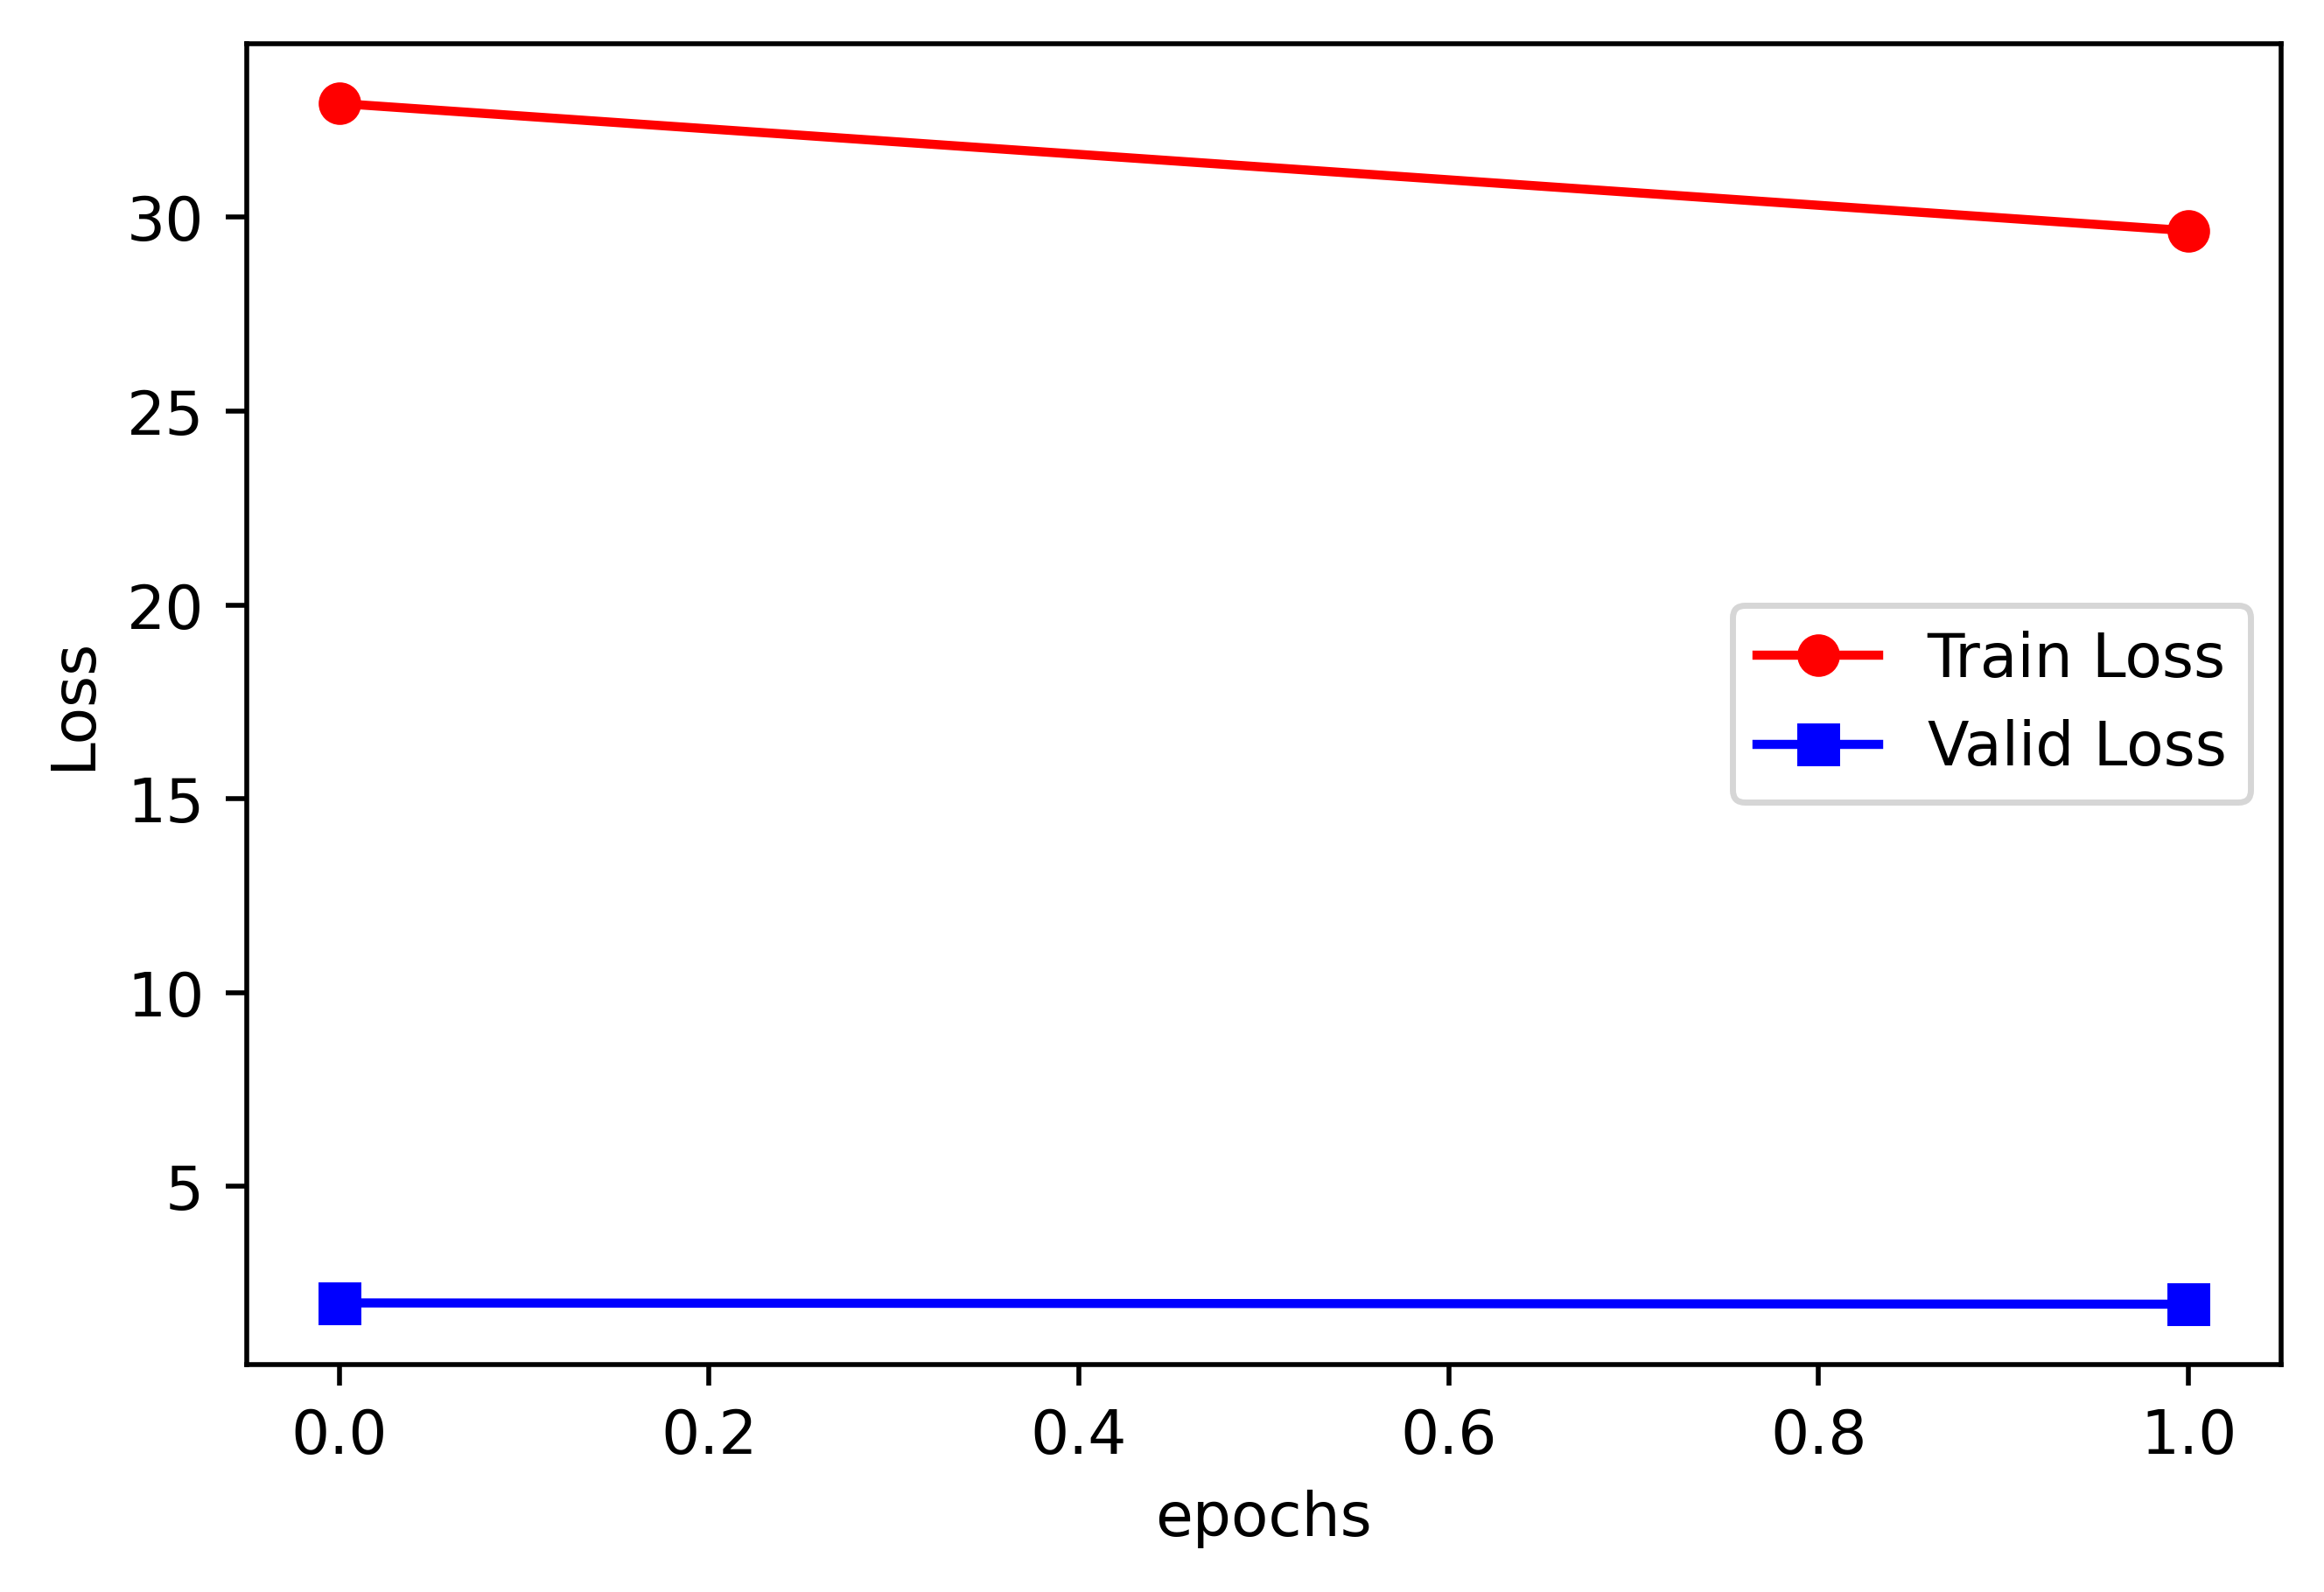

In [4]:
input_path = "../input/jrdr-deraining-dataset/JRDR/rain_data_train_Light/rain"
label_path = "../input/jrdr-deraining-dataset/JRDR/rain_data_train_Light/norain"
valid_input_path = '../input/jrdr-deraining-dataset/JRDR/rain_data_test_Light/rain/X2'
valid_label_path = '../input/jrdr-deraining-dataset/JRDR/rain_data_test_Light/norain'

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

net = Net().to(device)

learning_rate = 1e-3
batch_size = 50
epoch = 2
patience = 30
Loss_list = []
Valid_Loss_list = []

optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_f = nn.MSELoss()


if os.path.exists('./model.pth'): 
    print('Continue train with last model...')
    net.load_state_dict(torch.load('./model.pth'))
else: 
    print("Restart...")

dataset_train = MyTrainDataset(input_path, label_path)
dataset_valid = MyValidDataset(valid_input_path, valid_label_path)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, pin_memory=True)

stale = 0
best_valid_loss = 0
for i in range(epoch):
# ---------------Train----------------
    net.train()
    
    train_losses = []
    
    for batch in tqdm(train_loader):
        inputs, labels = batch
        
        outputs = net(inputs.to(device))
        loss = loss_f(outputs, labels.to(device))
        
        optimizer.zero_grad()
        
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(net.parameters(), max_norm=10)
        
        optimizer.step()
        
        train_losses.append(loss.item())
        
    train_loss = sum(train_losses)
    Loss_list.append(train_loss)
    print(f"[ Train | {i + 1:03d}/{epoch:03d} ] loss = {train_loss:.5f}")
    
# -------------Validation-------------
    net.eval()
    valid_losses = []
    for batch in tqdm(valid_loader):
        inputs, labels = batch
        
        with torch.no_grad():
            outputs = net(inputs.to(device))
        loss = loss_f(outputs, labels.to(device))
        
        valid_losses.append(loss.item())
    
    valid_loss = sum(valid_losses)
    Valid_Loss_list.append(valid_loss)
    print(f"[ Valid | {i + 1:03d}/{epoch:03d} ] loss = {valid_loss:.5f}")
    
    # Update logs
    if valid_loss > best_valid_loss:
        print(
            f"[ Valid | {i + 1:03d}/{epoch:03d} ] loss = {valid_loss:.5f} -> best")
    else:
        print(
            f"[ Valid | {i + 1:03d}/{epoch:03d} ] loss = {valid_loss:.5f}")
    
    if valid_loss > best_valid_loss:
        print(f'Best model found at epoch {i}, saving model')
        torch.save(net.state_dict(), f'model_best.ckpt')
        best_valid_loss = valid_loss
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f'No improvement {patience} consecutive epochs, early stopping.')
            break
            
plt.figure(dpi=500)
x = range(epoch)
y = Loss_list
plt.plot(x, y, 'ro-', label='Train Loss')
plt.plot(range(epoch), Valid_Loss_list, 'bs-', label='Valid Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()
plt.show()
        